In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats  # 信頼区間を描くために
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/multilevel_modeling.xlsx")

In [4]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [5]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [6]:
groups = df.groupby(df["id"])  # id とdata(age, height)

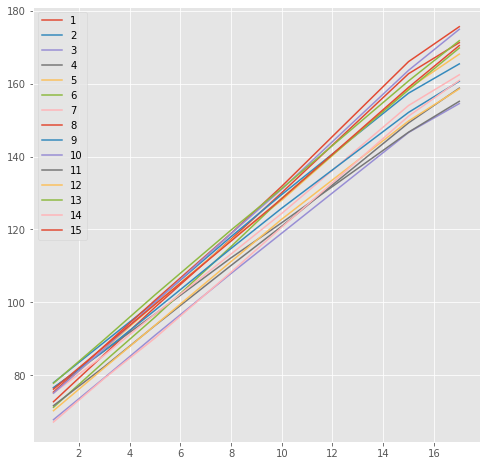

In [7]:
plt.figure(figsize=(8,8))
for name, group in groups:
    plt.plot(group["age"],group["height"],label=name)
plt.legend()

In [8]:
stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}

"""

↑　個人ごとの傾きのためのブロック： transformed parameters（共通部分＋個人差）　　a0 +a_id[n]

In [9]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_086a333d9101221579c8f12b530c2084 NOW.
In file included from /var/folders/b2/qd1flk0n1g975j_2k2fptczc0000gn/T/pystan_a2qcd9zb/stanfit4anon_model_086a333d9101221579c8f12b530c2084_1013489438201352534.cpp:777:
In file included from /Users/sueno/PythonWP/venv3.8.13/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/sueno/PythonWP/venv3.8.13/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/sueno/PythonWP/venv3.8.13/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1960:
/Users/sueno/PythonWP/venv3.8.13/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/b2/qd1flk0n1

In [10]:
stan_data = {"N":df.shape[0], "N_id":15, "X":df["age"], "Y":df["height"], "s_id":df["id"]}

In [ ]:
fit = sm.sampling(data = stan_data, iter=3000, warmup=1000, chains=3, seed=123)

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/sueno/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/sueno/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/sueno/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/sueno/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'stanfit4anon_model_086a333d9101221579c8f12b530c2084_1013489438201352534'
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/sueno/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/sueno/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in r

In [ ]:
fit

In [ ]:
plt.figure(figsize=(12,20))
fig = fit.plot()

In [ ]:
import arviz
arviz.plot_trace(fit);

In [ ]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [ ]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:,0] * x[i] + ms_b[:,0]

In [ ]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [ ]:
df_0 = groups.get_group(1)  # IDを指定し、グループ化されたデータを取得（１番のひとだけ）

In [ ]:
df_0.head()

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(df_0["age"],df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")